# ***Building a Movie Recommendation System Using Synopses With K-Means Clustering***

**Try our WebApp (Sypflix) by following** the `README.md`**!**

Github Repository: [https://github.com/CS-180-Group-4/Movie-Recommendation-System](https://github.com/CS-180-Group-4/Movie-Recommendation-System) 

Letterboxd Dataset: [https://www.kaggle.com/datasets/gsimonx37/letterboxd?select=movies.csv](https://www.kaggle.com/datasets/gsimonx37/letterboxd?select=movies.csv)

## Preliminaries

---

### Imports

We define first the necessary imports for the project. Make sure you have read first the `README.md` or at least ran `pip install -r requirements.txt` before proceeding!

In [2]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np


from time import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.metrics import silhouette_samples, silhouette_score

In [3]:
# Allows auto reloading of modules
%load_ext autoreload
%autoreload 2

In [4]:
# Add path to src folder to the path variable 
PATH_TO_SRC = "./src"

if PATH_TO_SRC not in sys.path:
  sys.path.append(PATH_TO_SRC)

For this project, two classes were defined to do the preprocessing and clustering steps, namely, `DataPreprocessor` and `DataClusterer`. The `DataPreprocessor` class is responsible for applying the preprocessing methods to the data. 
This includes removing irrelevant columns, removing rows with null values, removing stop words, vectorizing the data, and lastly, reducing dimensionality via Latent Semantic Analysis (LSA). On the other hand, the `DataClusterer` class is responsible for clustering the data and applying the correct labels to each entry. It also contains the important method for optimizing the number of clusters. 


In [5]:
# Local imports from .py files
from data_preprocessor import DataPreprocessor
from data_clusterer import DataClusterer

#### Parameters
We get the variables (i.e. the parameters for the model) from `src/config.py`. This section also includes a sample input to the model.

In [6]:
from config import MOVIES_PATH, GENRES_PATH, TEST_SIZE, RANDOM_STATE, MAX_DF, MIN_DF, STOP_WORDS, N_COMPONENTS, NORMALIZER_COPY, N_CLUSTERS, MAX_ITER, N_INIT, OPTIMAL_K

In [7]:
INPUT = "Dr. Kenzou Tenma, an elite neurosurgeon recently engaged to his hospital director's daughter, is well on his way to ascending the hospital hierarchy. That is until one night, a seemingly small event changes Dr. Tenma's life forever. While preparing to perform surgery on someone, he gets a call from the hospital director telling him to switch patients and instead perform life-saving brain surgery on a famous performer. His fellow doctors, fiancée, and the hospital director applaud his accomplishment; but because of the switch, a poor immigrant worker is dead, causing Dr. Tenma to have a crisis of conscience. So when a similar situation arises, Dr. Tenma stands his ground and chooses to perform surgery on the young boy Johan Liebert instead of the town's mayor. Unfortunately, this choice leads to serious ramifications for Dr. Tenma—losing his social standing being one of them. However, with the mysterious death of the director and two other doctors, Dr. Tenma's position is restored. With no evidence to convict him, he is released and goes on to attain the position of hospital director. Nine years later when Dr. Tenma saves the life of a criminal, his past comes back to haunt him—once again, he comes face to face with the monster he operated on. He must now embark on a quest of pursuit to make amends for the havoc spread by the one he saved."

#### Instantiated classes
We instantiate the `KMeans` object with the number of clusters `N_CLUSTERS`, the maximum number of iterations `MAX_ITER` and the number of initializations `N_INIT`.

In [8]:
kmeans = KMeans(n_clusters=N_CLUSTERS, max_iter=MAX_ITER, n_init=N_INIT)

## Preprocessing

---

We will now preprocess the data using the `DataPreprocessor` class defined in `src/data_preprocessor.py`, which contains the following methods:

- `countGenres()`: **Count** the number of unique genres in the dataset.

- `handleDataFrame()`: **Removes** duplicate rows from `df_genres`, **merges** it with `df_movies`, **drops** certain columns from `df_movies`, and **filters** out rows with null values in the *description* column.

- `vectorizeData()`: **Converts** a collection of raw data into a matrix of TF-IDF (Term Frequency-Inverse Document Frequency) features. *(More on this later)*

- `reduceDim()`: **Performs** dimensionality reduction on a given dataset using the TruncatedSVD algorithm. *(More on this later)*

In [9]:
preprocessor = DataPreprocessor(MOVIES_PATH, GENRES_PATH)
preprocessor.df_movies.head()

,id,name,date,tagline,description,minute,rating
0,1000001,Barbie,2023.0,She's everything. He's just Ken.,Barbie and Ken are having the time of their li...,114.0,3.91
1,1000002,Parasite,2019.0,Act like you own the place.,"All unemployed, Ki-taek's family takes peculia...",133.0,4.57
2,1000003,Everything Everywhere All at Once,2022.0,The universe is so much bigger than you realize.,An aging Chinese immigrant is swept up in an i...,140.0,4.32
3,1000004,Fight Club,1999.0,Mischief. Mayhem. Soap.,A ticking-time-bomb insomniac and a slippery s...,139.0,4.27
4,1000005,Interstellar,2014.0,Mankind was born on Earth. It was never meant ...,The adventures of a group of explorers who mak...,169.0,4.32


In [10]:
preprocessor.df_genres.head(20)

,id,genre
0,1000001,Comedy
1,1000001,Fantasy
2,1000001,Adventure
3,1000002,Comedy
4,1000002,Thriller
5,1000002,Drama
6,1000003,Science Fiction
7,1000003,Action
8,1000003,Adventure
9,1000004,Drama


#### Data Cleaning
We perform here data cleaning using the method `handleDataFrame`.

In [11]:
preprocessor.handleDataFrame()

Reduced Length:  540740
Reduced Columns:  Index(['id', 'genre', 'name', 'description', 'rating'], dtype='object')


We also append the model input already even before clustering. This way, LSA can work properly.

*Note: Applying clustering first, exporting the clustered data, and then fitting the input does not work since LSA would have to be applied to a single sample (the input itself). However, the result of this reduction would only be the 2D array `[[1]]`.*

In [12]:
preprocessor.df_movies.loc[-1] = [None, None, None, INPUT, None] # Set input as first row of data
preprocessor.df_movies.index += 1
preprocessor.df_movies.sort_index()
X_desc_only = preprocessor.df_movies.description

C:\Users\Rohan\AppData\Local\Temp\ipykernel_20212\3370382590.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  preprocessor.df_movies.loc[-1] = [None, None, None, INPUT, None] # Set input as first row of data


#### Vectorization
We will now explore the vectorization of the dataset through the following steps.
1. The method `vectorizeData` has the following parameters:

    - `X`: A pandas DataFrame containing the raw data.

    - `max_df`:  A float or integer representing the maximum document frequency threshold. Terms with a document frequency higher than this threshold will be ignored.

    - `min_df`: An integer representing the minimum document frequency threshold. Terms with a document frequency lower than this threshold will be ignored.

    - `custom_stop_words`: A dictionary of custom stop words to be added to the existing English stop words.
    
    - `verbose`: A boolean indicating whether to print additional information during the vectorization process.

2. It combines the existing English stop words along with the custom stop words provided.

3. It creates an instance of the `TfidfVectorizer` class, which is a subclass of `CountVectorizer`. `CountVectorizer` is responsible for converting a collection of text documents into a matrix of token counts.

4. It sets the parameters of the TfidfVectorizer instance, including `max_df`, `min_df`, and `stop_words`.

5. It measures the time it takes to vectorize the data by calling the `fit_transform` method of the `TfidfVectorizer` instance on the input data `X`. This method converts the raw data into a matrix of TF-IDF features.

6. It calculates the time taken for vectorization and prints it if the verbose parameter is set to `True`.

7. It prints additional information about the vectorized data, including the number of samples, number of features, and percentage of nonzero entries.

8. Finally, it returns the vectorized data (`X_tfidf`) and the feature names obtained from the `TfidfVectorizer` instance.

In [13]:
X_tfidf, features = preprocessor.vectorizeData(X_desc_only, MAX_DF, MIN_DF) # Vectorize

Vectorized in 10.196 s
# of Samples: 540741
# of Features: 98580
% of Nonzero Entries: 0.007


#### Dimensionality Reduction

In performing dimensional reduction, the following steps were done.

1. The method `reduceDim` has the following parameters:

    - `X`: A pandas DataFrame representing the input data.

    - `num_comp`: An integer specifying the desired dimensionality of the output data.

    - `normalizer_copy`: A boolean indicating whether to create a copy of the normalizer.

    - `verbose`: A boolean indicating whether to print verbose output.

2. The method first creates a pipeline using the `make_pipeline` function, which chains together the TruncatedSVD transformer and the Normalizer transformer. The TruncatedSVD transformer performs the dimensionality reduction, while the Normalizer transformer normalizes the data.

3. Next, the method fits the pipeline to the input data (`X`) using the `fit_transform method`. This step reduces the dimensionality of the data and returns the transformed data (`X_lsa`).

4. The method then calculates the explained variance of the SVD step and the time taken for the dimensionality reduction. If the `verbose` parameter is set to `True`, it prints the time taken and the explained variance.

5. Finally, the method returns the transformed data (`X_lsa`) and the pipeline (`lsa`).

In [14]:
genres = preprocessor.countGenres()
X_lsa, lsa = preprocessor.reduceDim(X_tfidf, N_COMPONENTS, NORMALIZER_COPY)

# of Genres:  19
Unique Genres:
                     id
genre                  
Action            19194
Adventure          8827
Animation         39939
Comedy            89726
Crime             15459
Documentary      138760
Drama            153192
Family            12476
Fantasy            9163
History            7233
Horror            31020
Music             29414
Mystery            8362
Romance           23825
Science Fiction    9519
TV Movie          10236
Thriller          21435
War                4647
Western            6205
LSA done in 10.172 s
Explained variance of the SVD step: 4.8%


## Clustering and Optimizing K

---

In [ ]:
'''
silhouettes = []

for i in range(2, N_CLUSTERS + 1):
    kmeans = KMeans(n_clusters=i)
    print("Insantiated", i)
    kmeans.fit(X_lsa)
    print("Model fitted")
    silhouettes.append(silhouette_score(X_lsa, kmeans.labels_))
    print("Silhouette computed")

plt.plot(range(2, N_CLUSTERS + 1), silhouettes, 'bx-')
plt.xlabel('K value')
plt.ylabel('Silhouette')
plt.show()
'''

In [ ]:
clusterer = DataClusterer(X_lsa, N_CLUSTERS, MAX_ITER, N_INIT)

In [19]:
centers, y_kmeans, inertia = clusterer.computeKMeans(OPTIMAL_K)
clusterer.getClusters(OPTIMAL_K, centers, features, lsa)

Cluster 0: work journey way history american people years look past music different make art time like black based human stories women 
Cluster 1: documentary short making history interviews people work footage feature world years american music series scenes explores follows art look journey 
Cluster 2: police help goes gang brother murder killer money gets team little detective crime fight men just order save set sister 
Cluster 3: father day time friends wife mother night girl home house group friend town people years finds small son gets husband 
Cluster 4: story tells based true love people young years set time man journey war told short history follows american way girl 
Cluster 5: man young wife woman finds old tries past mysterious goes gets help meets death time night way father day girlfriend 
Cluster 6: young woman husband girl men finds couple people help women mother goes boy meets man way beautiful father mysterious home 
Cluster 7: new york city years year work young hel

In [20]:
distances = []

for i in range(len(X_lsa)):
    dist = np.linalg.norm(X_lsa[0] - X_lsa[i])
    distances.append(round(dist, 4))

X_clustered  = preprocessor.df_movies.assign(similarity=distances)
X_clustered = X_clustered.assign(cluster=y_kmeans)
recommendations = X_clustered.loc[X_clustered['cluster'] == X_clustered.loc[0]['cluster']].sort_values('similarity', ascending=True).head(20)

In [21]:
recommendations

,id,genre,name,description,rating,similarity,cluster
352226,1412213,Comedy,The Bahama Hustle,Two up-n-coming rappers Ace and Cool breeze dr...,NaN,0.7657,2
73009,1074241,Science Fiction,Mighty Jack,The organization Mighty Jack is formed to comb...,2.56,0.7869,2
68212,1069232,Drama,Dear Nathan: Thank You Salma,Nathan and Salma enter the world of social act...,3.18,0.8087,2
254136,1283149,Horror,Face Eater,Mild-mannered bookstore owner and comic book d...,NaN,0.8144,2
180792,1193400,Science Fiction,Magus,Since the dawn of time magic users have availe...,NaN,0.8416,2
126548,1131719,Horror,The Last Exorcist,When Joan discovers her sister has been posses...,NaN,0.8440,2
1676,1001677,Comedy,Austin Powers: The Spy Who Shagged Me,"When diabolical genius, Dr. Evil travels back ...",3.25,0.8444,2
621196,1846523,Crime,Seven Dead Men,Seven Dead Men tells the tale of a caper gone ...,NaN,0.8458,2
164460,1174458,Comedy,Hot Air Aces,"Despite the title, the vehicles here are airpl...",NaN,0.8611,2
49578,1050000,Science Fiction,Monster SeaFood Wars,"Yuta, a young master at the Tsukiji Fish Marke...",3.10,0.8632,2


In [ ]:
# np.save('cluster_centers.npy', centers) # Centroids
# np.save('vectorized_data.npy', X_lsa) # Data as 'points'
# X_train_clustered.to_csv('clustered_movies.csv') # Data as presented to user

## Results and Discussion

---

### Elbow Method Result

After trying to visualize the inertias for various numbers of `K`, we've found out that there is no elbow in our graph (i.e. there is no defined value for `K` such that it is optimal). One possible explanation for this is that plot descriptions (and movies in general) may contain elements from the different topics. As such, trying to group the data would prove to be difficult. Nevertheless, our group decided to use a sufficiently and relatively high value for `K` which resulted in some level of coherence. 

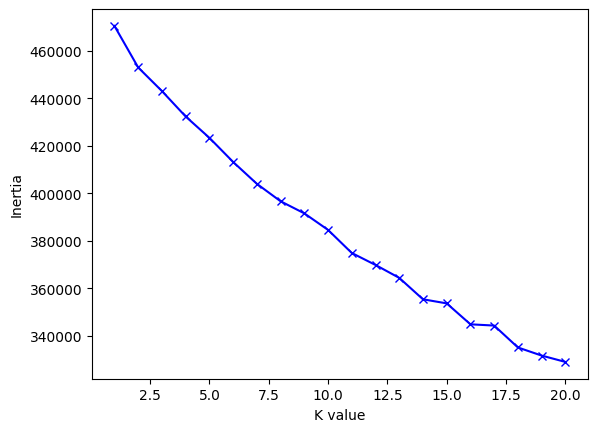

In [22]:
K, inertias = clusterer.computeKMeansInertia()

### Top Movies per Cluster (Based on Rating)

Listed below are the top 5 movies based on rating for each of the cluster. Note that the numbering of these clusters may change each time clustering is executed.

#### Cluster 0

In [28]:
X_clustered.loc[X_clustered['cluster'] == 0].sort_values('rating', ascending=False).drop(columns=["similarity"]).head()

,id,genre,name,description,rating,cluster
8625,1008644,Documentary,Blue Planet II,There is nowhere more powerful and unforgiving...,4.50,0
3465,1003466,War,Night and Fog,Filmmaker Alain Resnais documents the atrociti...,4.49,0
10740,1010761,Documentary,Cosmos: A Personal Voyage,Carl Sagan covers a wide range of scientific s...,4.48,0
13111,1013132,Documentary,The History of the Seattle Mariners,"Every team has its highs and lows, frustration...",4.45,0
1799,1001800,Drama,Andrei Rublev,"An expansive Russian drama, this film focuses ...",4.42,0


#### Cluster 1

In [29]:
X_clustered.loc[X_clustered['cluster'] == 1].sort_values('rating', ascending=False).drop(columns=["similarity"]).head()

,id,genre,name,description,rating,cluster
3391,1003392,Documentary,No Half Measures: Creating the Final Season of...,A documentary about the making of season five ...,4.64,1
5587,1005590,Family,Planet Earth II,David Attenborough presents a documentary seri...,4.60,1
4804,1004805,Documentary,Planet Earth,David Attenborough celebrates the amazing vari...,4.57,1
3881,1003882,Documentary,Shoah,Claude Lanzmann directed this 9½ hour document...,4.49,1
8806,1008825,Documentary,Our Planet,Experience our planet's natural beauty and exa...,4.45,1


#### Cluster 2

In [30]:
X_clustered.loc[X_clustered['cluster'] == 2].sort_values('rating', ascending=False).drop(columns=["similarity"]).head()

,id,genre,name,description,rating,cluster
1638,1001639,Animation,Cowboy Bebop,"In 2071, roughly fifty years after an accident...",4.65,2
3498,1003499,Comedy,Fullmetal Alchemist: Brotherhood,Edward and Alphonse Elric's reckless disregard...,4.63,2
2557,1002558,Drama,When They See Us,Five teens from Harlem become trapped in a nig...,4.55,2
453,1000453,Western,"The Good, the Bad and the Ugly",While the Civil War rages on between the Union...,4.49,2
132,1000132,Adventure,The Lord of the Rings: The Return of the King,Aragorn is revealed as the heir to the ancient...,4.49,2


#### Cluster 3

In [31]:
X_clustered.loc[X_clustered['cluster'] == 3].sort_values('rating', ascending=False).drop(columns=["similarity"]).head()

,id,genre,name,description,rating,cluster
2112,1002113,Drama,Band of Brothers,Drawn from interviews with survivors of Easy C...,4.68,3
3598,1003599,Mystery,Monster,"Kenzou Tenma, a Japanese brain surgeon in Germ...",4.62,3
917,1000917,Comedy,Over the Garden Wall,"Two brothers, Wirt and Greg, find themselves l...",4.61,3
524,1000524,Drama,Seven Samurai,A samurai answers a village's request for prot...,4.60,3
1416,1001416,Mystery,Twin Peaks: The Return,Picks up 25 years after the inhabitants of a q...,4.59,3


#### Cluster 4

In [32]:
X_clustered.loc[X_clustered['cluster'] == 4].sort_values('rating', ascending=False).drop(columns=["similarity"]).head()

,id,genre,name,description,rating,cluster
665,1000665,Drama,Chernobyl,The true story of one of the worst man-made ca...,4.57,4
83,1000083,Drama,GoodFellas,"The true story of Henry Hill, a half-Irish, ha...",4.48,4
3159,1003160,Drama,I May Destroy You,"Set in London, where gratification is only an ...",4.47,4
8233,1008252,Documentary,The Vietnam War,An immersive 360-degree narrative telling the ...,4.43,4
1467,1001468,History,The Passion of Joan of Arc,"A classic of the silent age, this film tells t...",4.43,4


#### Cluster 5

In [33]:
X_clustered.loc[X_clustered['cluster'] == 5].sort_values('rating', ascending=False).drop(columns=["similarity"]).head()

,id,genre,name,description,rating,cluster
4351,1004352,Animation,Berserk,"Guts, a man who calls himself ""The Black Sword...",4.53,5
1051,1001051,Drama,Ikiru,Kanji Watanabe is a middle-aged man who has wo...,4.51,5
4920,1004921,Comedy,The Tatami Galaxy,When a college dropout stops for a late night ...,4.46,5
1034,1001034,History,Mirror,A dying man in his forties recalls his childho...,4.34,5
1988,1001989,Drama,Paper Moon,"During the Great Depression, a con man finds h...",4.32,5


#### Cluster 6

In [34]:
X_clustered.loc[X_clustered['cluster'] == 6].sort_values('rating', ascending=False).drop(columns=["similarity"]).head()

,id,genre,name,description,rating,cluster
240,1000240,Drama,12 Angry Men,The defense and the prosecution have rested an...,4.62,6
1280,1001280,Thriller,Twin Peaks,An idiosyncratic FBI agent investigates the mu...,4.60,6
357,1000357,Drama,La Haine,After a chaotic night of rioting in a marginal...,4.51,6
7245,1007257,Crime,National Theatre Live: Prima Facie,"Tessa is a young, brilliant barrister. From wo...",4.51,6
3634,1003635,Drama,Nana,Nana Osaki is a guarded and ambitious young wo...,4.50,6


#### Cluster 7

In [35]:
X_clustered.loc[X_clustered['cluster'] == 7].sort_values('rating', ascending=False).drop(columns=["similarity"]).head()

,id,genre,name,description,rating,cluster
65,1000065,Crime,The Shawshank Redemption,Framed in the 1940s for the double murder of h...,4.55,7
1510,1001511,Documentary,Paris Is Burning,"Where does voguing come from, and what, exactl...",4.47,7
18,1000018,Science Fiction,Spider-Man: Across the Spider-Verse,"After reuniting with Gwen Stacy, Brooklyn’s fu...",4.47,7
816,1000816,Drama,The Apartment,Bud Baxter is a minor clerk in a huge New York...,4.43,7
20885,1020930,Music,The 1975 'At Their Very Best' Live from Madiso...,In support of their fifth studio album 'Being ...,4.41,7


#### Cluster 8

In [36]:
X_clustered.loc[X_clustered['cluster'] == 8].sort_values('rating', ascending=False).drop(columns=["similarity"]).head()

,id,genre,name,description,rating,cluster
3276,1003277,Drama,The Human Condition III: A Soldier's Prayer,"After the Japanese defeat to the Russians, Kaj...",4.55,8
6496,1006501,Drama,Fanny and Alexander,"Through the eyes of ten-year-old Alexander, we...",4.49,8
377,1000377,War,Grave of the Fireflies,"In the final months of World War II, 14-year-o...",4.45,8
11249,1011270,Comedy,James Acaster: Cold Lasagne Hate Myself 1999,"On December 17th 2019, I, James Acaster, filme...",4.39,8
1341,1001341,Animation,It's Such a Beautiful Day,Bill struggles to put together his shattered p...,4.38,8


#### Cluster 9

In [37]:
X_clustered.loc[X_clustered['cluster'] == 9].sort_values('rating', ascending=False).drop(columns=["similarity"]).head()

,id,genre,name,description,rating,cluster
2555,1002556,Music,The Beatles: Get Back,"The three-part documentary series, compiled fr...",4.53,9
9164,1009183,Documentary,Avatar Spirits,"Bryan Konietzko and Michael Dante DiMartino, c...",4.52,9
15774,1015805,Comedy,Nirvanna the Band the Show,Musicians Matt and Jay attempt to achieve thei...,4.52,9
15444,1015474,Documentary,Tapping the Wire,Long-time Wire fan Charlie Brooker takes a jou...,4.50,9
3165,1003166,Documentary,As I Was Moving Ahead Occasionally I Saw Brief...,Director Jonas Mekas provides an intimate glim...,4.46,9


#### Cluster 10

In [38]:
X_clustered.loc[X_clustered['cluster'] == 10].sort_values('rating', ascending=False).drop(columns=["similarity"]).head()

,id,genre,name,description,rating,cluster
6462,1006467,Drama,Ping Pong the Animation,"Makoto ""Smile"" Tsukimoto and his friend Yutaka...",4.53,10
4209,1004210,Documentary,O.J.: Made in America,A chronicle of the rise and fall of O.J. Simps...,4.44,10
8286,1008305,Drama,Revolutionary Girl Utena,Utena is a tomboyish school girl who attends t...,4.38,10
3451,1003452,Documentary,Hoop Dreams,"Every school day, African-American teenagers W...",4.38,10
3930,1003931,Drama,Red Beard,Aspiring to an easy job as personal physician ...,4.31,10


#### Cluster 11

In [39]:
X_clustered.loc[X_clustered['cluster'] == 11].sort_values('rating', ascending=False).drop(columns=["similarity"]).head()

,id,genre,name,description,rating,cluster
3299,1003300,Drama,Dekalog,"Originally made for Polish television, “The De...",4.56,11
1286,1001286,Crime,A Brighter Summer Day,"A boy experiences first love, friendships and ...",4.49,11
3331,1003332,Romance,Nathan for You: Finding Frances,Nathan attempts to help a Bill Gates impersona...,4.47,11
625,1000625,Drama,Cinema Paradiso,"A filmmaker recalls his childhood, when he fel...",4.44,11
732,1000732,Drama,Normal People,Marianne and Connell weave in and out of each ...,4.41,11


#### Cluster 12

In [40]:
X_clustered.loc[X_clustered['cluster'] == 12].sort_values('rating', ascending=False).drop(columns=["similarity"]).head()

,id,genre,name,description,rating,cluster
1278,1001278,Music,Stop Making Sense,A concert film documenting Talking Heads at th...,4.66,12
4560,1004561,Documentary,Radiohead: In Rainbows – From the Basement,A live performance by Radiohead of their 2007 ...,4.63,12
7149,1007161,Music,Nirvana: Unplugged In New York,"A live album by American rock band Nirvana, th...",4.50,12
2609,1002610,Music,Taylor Swift: Reputation Stadium Tour,Taylor Swift takes the stage in Dallas for the...,4.46,12
2721,1002722,Music,Folklore: The Long Pond Studio Sessions,"An intimate concert film, in which Taylor Swif...",4.46,12


#### Cluster 13

In [41]:
X_clustered.loc[X_clustered['cluster'] == 13].sort_values('rating', ascending=False).drop(columns=["similarity"]).head()

,id,genre,name,description,rating,cluster
871,1000871,History,Harakiri,Down-on-his-luck veteran Tsugumo Hanshirō ente...,4.68,13
433,1000433,War,Come and See,The invasion of a village in Byelorussia by Ge...,4.64,13
220,1000220,Crime,The Godfather: Part II,In the continuing saga of the Corleone crime f...,4.59,13
2074,1002075,Comedy,National Theatre Live: Fleabag,"Fleabag may seem oversexed, emotionally unfilt...",4.59,13
2,1000002,Comedy,Parasite,"All unemployed, Ki-taek's family takes peculia...",4.57,13


#### Cluster 14

In [42]:
X_clustered.loc[X_clustered['cluster'] == 14].sort_values('rating', ascending=False).drop(columns=["similarity"]).head()

,id,genre,name,description,rating,cluster
3954,1003955,Music,Renaissance: A Film by Beyoncé,Accentuates the journey of Renaissance World T...,4.55,14
183,1000183,History,Schindler's List,The true story of how businessman Oskar Schind...,4.51,14
2860,1002861,War,The Human Condition I: No Greater Love,"During the Second World War, Japanese conscien...",4.48,14
16390,1016422,Documentary,The World at War,A documentary series that gives a historical a...,4.47,14
7,1000007,Adventure,Spider-Man: Into the Spider-Verse,Struggling to find his place in the world whil...,4.43,14


## WebApp Screenshots

---

![WebApp Input](./img/webapp_initial.png)


![WebApp Output](./img/webapp_final.png)


![WebApp Output (2)](./img/webapp_extra.png)


## References

---

1. Bergamaschi, S., & Po, L. Comparing LDA and LSA Topic Models for Content-Based Movie Recommendation Systems. https://dbgroup.ing.unimore.it/~po/pubs/LNBI_2015.pdf

2. Garanin, S. Letterboxd dataset. https://www.kaggle.com/datasets/gsimonx37/letterboxd, 2024.

3. Ioana. Latent semantic analysis: Intuition, math, implementation. https://towardsdatascience.com/latent-semantic-analysis-intuition-math-implementation-a194aff870f8, May 10 2020.

4. Ibtesam, A. Getting started with a movie recommendation system. https://www.kaggle.com/code/ibtesama/getting-started-with-a-movie-recomme ndation-system/notebook, 2024.

5. Javatpoint. K-means clustering algorithm. https://www.javatpoint.com/k-means-clustering-algorithm-in-machine-learning, n.d.

6. Scikit learn. Clustering text documents using K-means. https://scikit-learn.org
/stable/auto_examples/text/plot_document_clustering.html, n.d.

7. Scikit learn. TruncatedSVD.
https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.Tr
uncatedSVD.html#sklearn.decomposition.TruncatedSVD, n.d.

8. Tomar, A. Elbow Method. https://builtin.com/data-science/elbow-method,
August 2 2023.

9. Zhang, J., Wang, Y., Yuan, Z., and Jin, Q. Personalized real-time movie recommendation system: Practical prototype and evaluation. Tsinghua Science and Technology 25, 2 (2020), 180–191.